In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sys 
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
!cd OutputData && ls

stop_output_high.csv stop_output_med.csv  trip_output_low.csv
stop_output_low.csv  trip_output_high.csv trip_output_med.csv


In [3]:
trip = pd.read_csv("OutputData/trip_output_high.csv", sep=";")
stop = pd.read_csv("OutputData/stop_output_high.csv", sep=";")
# trip = pd.read_csv("OutputData/trip_output_med.csv", sep=";")
# stop = pd.read_csv("OutputData/stop_output_med.csv", sep=";")
# trip = pd.read_csv("OutputData/trip_output_low.csv", sep=";")
# stop = pd.read_csv("OutputData/stop_output_low.csv", sep=";")

In [4]:
dur_mean = trip['tripinfo_duration'].mean()
trip.loc[trip['tripinfo_duration']>3600, 'tripinfo_duration'] = dur_mean
terminal = []
for i in trip.tripinfo_id:
    
    position = i.find('_')
    t = i[:position]
    if len(t) == 2:
        t = t[1]
    terminal.append(t)
trip['terminal'] = terminal

In [5]:
#global variables
AM = [4,9]
MID = [9,15]
PM = [15,18]


# Cleaning and Processing the Data

In [6]:
bus = stop.loc[stop['stopinfo_type'] == 'bus']
bus.reset_index(inplace=True,drop=True)
bus['time_start'] = bus['stopinfo_started'].apply(lambda x: time.strftime('%H:%M:%S', time.gmtime(int(x))))
bus['time_end'] = bus['stopinfo_ended'].apply(lambda x: time.strftime('%H:%M:%S', time.gmtime(int(x))))
bus['hour_start'] = bus['stopinfo_started'].apply(lambda x: time.strftime('%H', time.gmtime(int(x))))
bus['hour_end'] = bus['stopinfo_ended'].apply(lambda x: time.strftime('%H', time.gmtime(int(x))))
bus['length_duration'] = bus['stopinfo_ended'].values - bus['stopinfo_started'].values
stop_name = []
for name in bus['stopinfo_busStop']:
    if name[0] == "R":
        stop = name[:9]
        stop_name.append(stop)
    else:
        stop = name[0]
        stop_name.append(stop)
bus['stop_name'] = stop_name

bus_names = bus['stopinfo_id'].unique()
dictionary = {}
for b in bus_names:
    tmp = bus.loc[bus['stopinfo_id'] == b]
    
    tmp.reset_index(inplace=True,drop=True)
    
    for i, row in enumerate(tmp['stop_name']):
        try:
            route = row + "_To_" + tmp['stop_name'][i+1]
            route_duration = tmp['stopinfo_ended'][i+1] - tmp['stopinfo_ended'][i]
            hour = tmp['hour_end'][i+1]
            if route not in dictionary:
                dictionary[route] = {"route_duration":[],"hour":[],"terminal":[]}
                dictionary[route]["route_duration"].append(route_duration)
                dictionary[route]['hour'].append(hour)
                dictionary[route]['terminal'].append(b[0])
            else:
                dictionary[route]["route_duration"].append(route_duration)
                dictionary[route]['hour'].append(hour)
                dictionary[route]['terminal'].append(b[0])
        except:
            pass
dframes = {}
for key in dictionary:
    dframes[key] = pd.DataFrame()
    dframes[key]["Travel_time"] = dictionary[key]["route_duration"]
    dframes[key]["Hour"] = dictionary[key]["hour"]
    dframes[key]["terminal"] = dictionary[key]["terminal"]


bus_fuel = trip.loc[trip['tripinfo_vType']=="bus"]
bus_fuel.reset_index(drop=True,inplace=True)
bus_fuel['Terminal'] = bus_fuel['tripinfo_id'].apply(lambda x: x[0])
bus_fuel['gallons'] = bus_fuel['emissions_fuel_abs'].values * 0.000264172
bus_fuel = bus_fuel[['gallons','tripinfo_duration','tripinfo_id','Terminal','tripinfo_routeLength']].groupby('Terminal').mean()
bus_fuel['Terminal'] = bus_fuel.index
bus_fuel.reset_index(inplace=True,drop=True)
number_of_trips = 65
for key in dframes:
    tmp = dframes[key]
    Terminal = dframes[key]['terminal'].unique()[0]
    bus_data = bus_fuel.loc[bus_fuel['Terminal'] == Terminal]
    Total_gallons = bus_data['gallons'].item()
    Duration = bus_data['tripinfo_duration'].item() 
    Distance = bus_data['tripinfo_routeLength'].item() * 0.000621371
    Fuel_usage = []
    distance = []
    
    for time in tmp['Travel_time']:
        percent_of_trip = time/Duration
        Fuel = Total_gallons * percent_of_trip
        Fuel_usage.append(Fuel)
        distance_of_trip = Distance - .55
        distance.append(distance_of_trip)
    dframes[key]['Fuel_usage_gallons'] = Fuel_usage
    dframes[key]['Distance_miles'] = distance

In [7]:
bus_fuel.head()

,gallons,tripinfo_duration,tripinfo_routeLength,Terminal
0,1.101369,182.765982,8373.304231,A
1,1.087629,142.354269,8307.128531,B
2,0.998224,151.857766,7449.873077,C
3,1.049988,158.406717,7983.893392,D
4,1.075766,193.053570,7830.496469,E


In [8]:
dframes['RAC_pick_To_E'].head()

,Travel_time,Hour,terminal,Fuel_usage_gallons,Distance_miles
0,334.00,00,E,1.861171,4.315643
1,336.25,00,E,1.873709,4.315643
2,334.00,00,E,1.861171,4.315643
3,341.00,01,E,1.900178,4.315643
4,338.25,01,E,1.884854,4.315643


# Aggregate the Data and get out what you need

- When you run this you will need to think about what route you want to 
  look at. 
- Here is the function:
    * GrabRouteData(start,end):
    * start options: < "A","B","C","D","E","R" >
    * end options: < "A","B","C","D","E","R" >
         * pointers: "R" is refering to the RAC and the other letters 
         * referring to the other terminals

In [9]:
def GrabRouteData(start,end):
    options = ["A","B","C","D","E","R"]
    if (start not in options) or (end not in options):
         sys.exit("Try again. Use any of these as an option A,B,C,D,E,R")
    if start == "R":
        start = "RAC_pick"
    if end == "R":
        end = "RAC_drop"
    
    route = start + "_To_" +end
    dframes[route]['hour'] = dframes[route]['Hour'].values
    dframes[route]['hour'] = pd.to_numeric(dframes[route]['hour'])
    df = cluster_hour(dframes[route],AM,MID,PM)
    grp_mean = df.groupby(['time_period']).mean()
    grp_std = df.groupby(['time_period']).std()
    grp_mean.fillna(0,inplace=True)
    grp_std.fillna(0,inplace=True)
    
       
    
    return grp_mean, grp_std


In [10]:
def cluster_hour(df,am,middle,pm):
    hour_factor = []
    for h in df['hour']:
        if h >= am[0] and h <= am[1]:
            hour_factor.append('am')
        elif h >= pm[0] and h <= pm[1]:
            hour_factor.append('pm')
        elif h >= middle[0] and h <= middle[1]:
            hour_factor.append('mid')
        else:
            hour_factor.append('op')
    df['time_period'] = hour_factor
    return df

In [11]:
def filter_bus_data(start,end,buses):    
    buses = trip[trip['tripinfo_vType'] == "bus"]
    buses['drop'] = buses['tripinfo_id'].apply(lambda x: x[2:5])
    buses.drop( buses[ buses['drop'] == 'bus' ].index , inplace=True)
    buses.reset_index(inplace=True,drop=True)
    buses['start'] = buses['tripinfo_id'].apply(lambda x: x[0])
    buses['end'] = buses['tripinfo_id'].apply(lambda x: x[1])
    buses['hour'] = buses['tripinfo_arrival'].apply(lambda x: round(x/3600) )
    buses['gallons'] = buses['emissions_fuel_abs'].values * 0.000264172
    buses['distance_miles'] = buses['tripinfo_routeLength'].values * 0.000621371
    filter_df = buses.loc[(buses['start'] == start) & (buses['end'] == end)]
    filter_df = filter_df[['gallons','distance_miles','tripinfo_duration','hour']]
    return filter_df
    


def group_data_by_time(df):
    grp_mean = df.groupby(['time_period']).mean()
    grp_std = df.groupby(['time_period']).std()
    
    grp_mean = grp_mean[['gallons','distance_miles','tripinfo_duration']]
    grp_std = grp_std[['gallons','distance_miles','tripinfo_duration']]
    grp_mean.fillna(0,inplace=True)
    grp_std.fillna(0,inplace=True)
    return grp_mean, grp_std



In [12]:
def generate_matrixes(agg,buses):
    matrix_dictionary = {}
    metrics = ['gallons','distance_miles','tripinfo_duration']
    time = ['am','mid','pm','op']
    for m in metrics:
        matrix_dictionary[m] = {}
        
        for t in time:

            data = np.zeros((6, 6))
            matrix = pd.DataFrame(data,columns=['A','B','C','D','E','R'],index=['A','B','C','D','E','R'])
            
            
            matrix_dictionary[m][t] = matrix
    
    terminals = ['A','B','C','D','E']
#     return matrix_dictionary

# def build_matrices(dictionary,buses,agg):
#     metrics = ['gallons','distance_miles','tripinfo_duration']
#     time = ['am','mid','pm','op']
    for start in terminals:
        for end in terminals:
            
            if start != end:
                filter_df = filter_bus_data(start,end,buses)
                clustered = cluster_hour(filter_df,AM,MID,PM)
                mn,std = group_data_by_time(clustered)
                
                for m in metrics:
                    for t in time:
                        
                        value_mean = mn[m][t]
                        value_std = std[m][t]
                        if agg == 'std':
                            value = value_std
                        else:
                            value = value_mean
                        matrix_dictionary[m][t][start][end] = value 

                        
    return matrix_dictionary




In [13]:
m,s= GrabRouteData("R","A")
s

,Travel_time,Fuel_usage_gallons,Distance_miles,hour
time_period,,,,
am,3.066401,0.018478,0.0,1.750541
mid,2.617740,0.015775,0.0,1.441153
op,2.319832,0.013980,0.0,9.762948
pm,2.805086,0.016904,0.0,1.101946


In [14]:
tmp = filter_bus_data('B','D',trip)
tmp.head()

,gallons,distance_miles,tripinfo_duration,hour
7,0.326773,1.572342,145.25,1
20,0.450477,1.738640,200.00,1
37,0.335843,1.689390,151.25,1
50,0.445555,1.738640,199.50,1
114,0.458089,1.855687,206.25,3


In [15]:
tmp = cluster_hour(tmp,AM,MID,PM)
tmp.head(10)

,gallons,distance_miles,tripinfo_duration,hour,time_period
7,0.326773,1.572342,145.25,1,op
20,0.450477,1.738640,200.00,1,op
37,0.335843,1.689390,151.25,1,op
50,0.445555,1.738640,199.50,1,op
114,0.458089,1.855687,206.25,3,op
127,0.371555,1.648677,159.75,3,op
135,0.317904,1.572342,144.50,3,op
160,0.374218,1.648677,160.25,3,op
177,0.322870,1.572342,145.00,4,am
199,0.260911,1.016905,104.25,4,am


In [16]:
m,s = group_data_by_time(tmp)
m

,gallons,distance_miles,tripinfo_duration
time_period,,,
am,0.323329,1.301451,130.026316
mid,0.378804,1.610431,163.785714
op,0.332675,1.401615,139.760000
pm,0.366036,1.542629,154.500000


In [17]:
f = filter_bus_data('B','D',trip)
c = cluster_hour(f,[4,9],[8,15],[15,18])
m,s = group_data_by_time(c)
m['gallons']

time_period
am     0.323329
mid    0.378804
op     0.332675
pm     0.366036
Name: gallons, dtype: float64

In [18]:
std_dictionary = generate_matrixes('std',trip)
mean_dictionary = generate_matrixes('mean',trip)

In [19]:
RAC = "R"
terminals = ['A','B','C','D','E']
metrics = ["Travel_time","Fuel_usage_gallons","Distance_miles"]
metrics_alt = ['tripinfo_duration','gallons','distance_miles']
period = ['am','pm','mid','op']
for t in terminals:
    
    table_vertical_mn,table_vertical_std = GrabRouteData(RAC,t)
    table_horizontal_mn,table_horizontal_std = GrabRouteData(t,RAC)

    for hour in period:
        count = 0
        for m in metrics:
            mv = table_vertical_mn[m][hour]
            stdv = table_vertical_std[m][hour]
            mh = table_horizontal_mn[m][hour]
            stdh = table_horizontal_std[m][hour]
            mean_dictionary[metrics_alt[count]][hour][RAC][t] = mv
            std_dictionary[metrics_alt[count]][hour][RAC][t] = stdv
            mean_dictionary[metrics_alt[count]][hour][t][RAC] = mh
            std_dictionary[metrics_alt[count]][hour][t][RAC] = stdh
            count+=1


# Options:
First pick mean or deviation dictionary
1. First Level: Metrics (i.e. full_matrix['tripinfo_duration'])
       * 'tripinfo_duration'
       * 'gallons'
       * 'distance_miles'
       
2. Time Period
       * 'am'
       * 'mid'
       * 'pm'
       * 'op'

3. Start Point & 4. End Point
       * 'A'
       * 'B'
       * 'C'
       * 'D'
       * 'E'
       * 'R'


In [20]:
mean_dictionary['gallons']['am']['A']['B']

0.31841973120198686

# Or to see Full matrix

In [21]:
mean_dictionary['gallons']['am']

,A,B,C,D,E,R
A,0.000000,0.313684,0.368312,0.397793,0.440752,2.368492
B,0.318420,0.000000,0.279175,0.382144,0.424743,3.525072
C,0.392780,0.329603,0.000000,0.279470,0.429721,2.697589
D,0.399063,0.323329,0.271572,0.000000,0.381338,3.128569
E,0.464747,0.421762,0.412517,0.279528,0.000000,1.878365
R,3.209896,3.416429,3.547280,2.745206,2.353666,0.000000


# We Can Visualize It Too!

Text(0.5, 1.0, 'Standard Deviation')

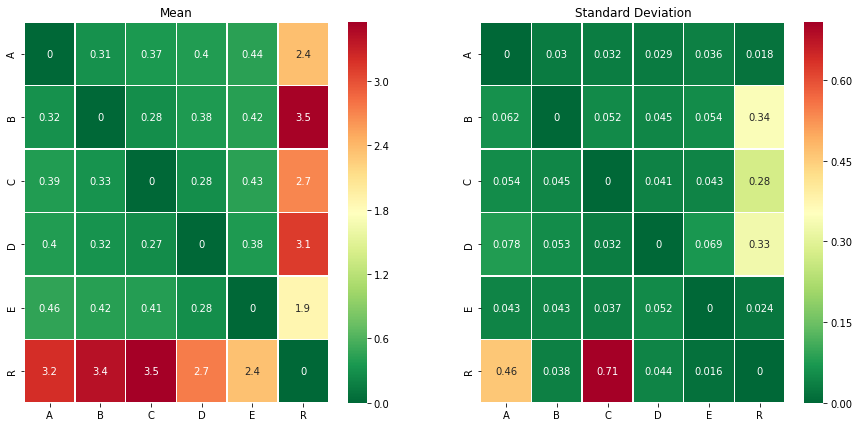

In [22]:
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.heatmap(mean_dictionary['gallons']['am'],
            cmap='RdYlGn_r', 
            linewidths=0.5,
            annot=True)
plt.title("Mean")
plt.subplot(1, 2, 2)
sns.heatmap(std_dictionary['gallons']['am'],
            cmap='RdYlGn_r', 
            linewidths=0.5,
            annot=True)
plt.title("Standard Deviation")

Text(0.5, 1.0, 'Standard Deviation')

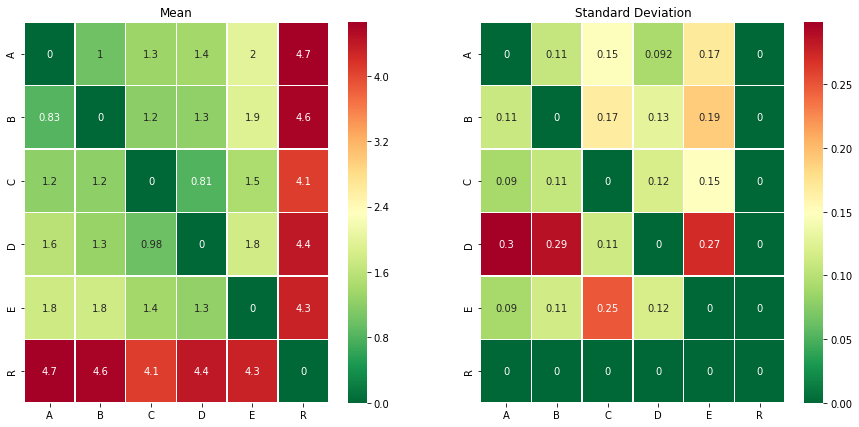

In [23]:
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.heatmap(mean_dictionary['distance_miles']['am'],
            cmap='RdYlGn_r', 
            linewidths=0.5,
            annot=True)
plt.title("Mean")
plt.subplot(1, 2, 2)
sns.heatmap(std_dictionary['distance_miles']['am'],
            cmap='RdYlGn_r', 
            linewidths=0.5,
            annot=True)
plt.title("Standard Deviation")

Text(0.5, 1.0, 'Standard Deviation')

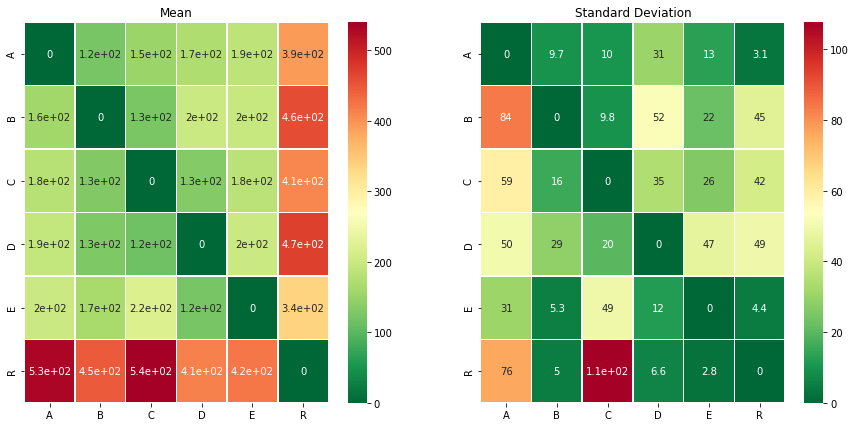

In [24]:
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.heatmap(mean_dictionary['tripinfo_duration']['am'],
            cmap='RdYlGn_r', 
            linewidths=0.5,
            annot=True)
plt.title("Mean")
plt.subplot(1, 2, 2)
sns.heatmap(std_dictionary['tripinfo_duration']['am'],
            cmap='RdYlGn_r', 
            linewidths=0.5,
            annot=True)
plt.title("Standard Deviation")

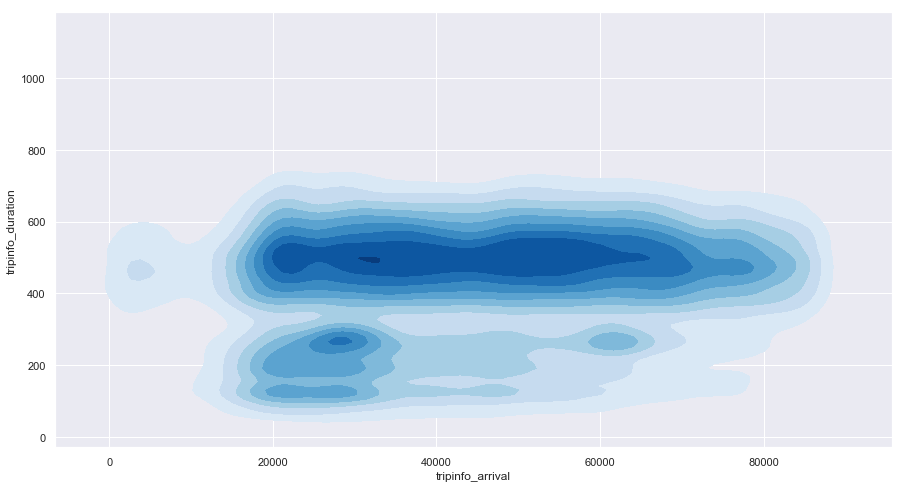

In [25]:
plt.figure(figsize=(15,8))
sns.set()

# sns.lmplot("tripinfo_arrival", "tripinfo_duration",hue="terminal", fit_reg=False,data=trip)
sns.kdeplot(trip.tripinfo_arrival, trip.tripinfo_duration,cmap="Blues", shade=True, shade_lowest=False)